In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_columns', 500)

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [108]:
data = pd.read_csv('../../documents/data/nyc_restaurants.csv')

In [109]:
#rename columns
data_names = ['id', 'name', 'boro','bldg_num','street','zipcode','phone','cuisine','inspect_date','action','violation_code','violation_desc','critical_flag','score','grade','grade_date','record_date','inspect_type']
data.columns = data_names
data.columns

Index(['id', 'name', 'boro', 'bldg_num', 'street', 'zipcode', 'phone',
       'cuisine', 'inspect_date', 'action', 'violation_code', 'violation_desc',
       'critical_flag', 'score', 'grade', 'grade_date', 'record_date',
       'inspect_type'],
      dtype='object')

In [110]:
data.shape

(385364, 18)

In [111]:
data.dtypes

id                int64  
name              object 
boro              object 
bldg_num          object 
street            object 
zipcode           float64
phone             object 
cuisine           object 
inspect_date      object 
action            object 
violation_code    object 
violation_desc    object 
critical_flag     object 
score             float64
grade             object 
grade_date        object 
record_date       object 
inspect_type      object 
dtype: object

In [221]:
data.head()


,id,name,boro,bldg_num,street,zipcode,phone,cuisine,inspect_date,action,violation_code,violation_desc,critical_flag,score,grade,grade_date,record_date,inspect_type
0,50014889,SHING WONG RESTAURANT,BROOKLYN,1232,AVENUE U,11229.0,9178072394,Chinese,10/26/2015,Violations were cited in the following area(s).,10F,"Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.",Not Critical,12.0,A,10/26/2015,03/18/2019,Cycle Inspection / Re-inspection
3,41154194,NATURALLY DELICIOUS CATERERS,BROOKLYN,487,COURT STREET,11231.0,7182373727,American,08/09/2018,Violations were cited in the following area(s).,10F,"Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.",Not Critical,2.0,A,08/09/2018,03/18/2019,Cycle Inspection / Initial Inspection
4,50061060,TEXAS CHICKEN & BURGERS,BRONX,3275,WESTCHESTER AVE,10461.0,6467758513,American,04/11/2017,Violations were cited in the following area(s).,10F,"Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.",Not Critical,12.0,A,04/11/2017,03/18/2019,Pre-permit (Operational) / Initial Inspection
10,50001583,GREEK XPRESS,BROOKLYN,263,PROSPECT PARK WEST,11215.0,7184991105,Greek,01/13/2017,Violations were cited in the following area(s).,09C,Food contact surface not properly maintained.,Not Critical,13.0,A,01/13/2017,03/18/2019,Cycle Inspection / Initial Inspection
11,41441583,FRITZIES BAKE SHOP,QUEENS,6910,ROOSEVELT AVENUE,11377.0,7185070205,Filipino,08/13/2018,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,18.0,B,08/13/2018,03/18/2019,Cycle Inspection / Re-inspection


### Drop Rows with Nan Grades

In [112]:
#drop rows with NaN grade values
data.dropna(subset=['grade'],inplace=True)
data.shape

(194336, 18)

In [113]:
# find indexes of rows where grade equals P, Z, G or Not Yet Graded
grade_delete = data[(data['grade'] == 'P') | (data['grade'] == 'Z') | (data['grade'] == 'G') | (data['grade'] == 'Not Yet Graded')].index

In [114]:
# drop those indexes
data.drop(grade_delete, inplace=True)

In [115]:
# check if dropped
data.shape

(186742, 18)

### Create Useful Functions

In [117]:
# get unique identifier of restaurant ID and inspection date
# drop duplicates
ids = data.loc[:,['id','inspect_date']].drop_duplicates()


In [118]:
ids.iloc[0]['id'] # first row, id column

50014889

In [119]:
ids.iloc[0]['inspect_date']

'10/26/2015'

In [120]:
ids['inspect_date'].iloc[0]

'10/26/2015'

In [121]:
# function to get column values
def get_columns(rest_id, col):
    return data[data['id']==rest_id].iloc[0][col]

In [122]:
# testing
get_columns(30075445,'cuisine')

'Bakery'

In [ ]:
# function to get number of violation codes
#def get_vcodes(rest_id, i_date, vcode):
#    return data[(data['id']==rest_id) & (data['inspect_date']==i_date) & (data['violation_code']==vcode)]['id'].count()

In [ ]:
# testing
#get_vcodes(30112340,'03/13/2018', '02G')

In [ ]:
#vcodes = data['violation_code'].unique()

In [ ]:
#data['violation_code'].nunique()

In [123]:
def get_critical_breakdown(rest_id,i_date):
    # return array 2 1 0 
    base = data[(data['id']==rest_id) & (data['inspect_date']==i_date)]
    critical_count = base[base['critical_flag']=='Critical']['critical_flag'].count()
    not_critical_count = base[base['critical_flag']=='Not Critical']['critical_flag'].count()
    not_applicable_count = base[base['critical_flag']=='Not Applicable']['critical_flag'].count()
    return critical_count, not_critical_count, not_applicable_count

In [124]:
get_critical_breakdown(30112340,'03/13/2018')

(1, 2, 0)

In [126]:
all_cfs = [get_critical_breakdown(i[0],i[1])for i in ids.values]
all_cfs

[(2, 1, 0),
 (0, 1, 0),
 (1, 2, 0),
 (1, 2, 0),
 (2, 1, 0),
 (2, 0, 0),
 (1, 1, 0),
 (3, 0, 0),
 (1, 2, 0),
 (2, 0, 0),
 (2, 0, 0),
 (1, 2, 0),
 (1, 0, 0),
 (1, 2, 0),
 (1, 1, 0),
 (1, 0, 0),
 (3, 1, 0),
 (1, 1, 0),
 (0, 2, 0),
 (1, 1, 0),
 (0, 2, 0),
 (1, 0, 0),
 (3, 1, 0),
 (2, 0, 0),
 (0, 3, 0),
 (2, 0, 0),
 (1, 2, 0),
 (0, 2, 0),
 (2, 1, 0),
 (1, 3, 0),
 (4, 2, 0),
 (1, 3, 0),
 (1, 2, 0),
 (1, 1, 0),
 (4, 1, 0),
 (2, 0, 0),
 (2, 0, 0),
 (4, 0, 0),
 (1, 1, 0),
 (2, 1, 0),
 (2, 1, 0),
 (2, 0, 0),
 (2, 2, 0),
 (1, 2, 0),
 (1, 2, 0),
 (1, 2, 0),
 (2, 0, 0),
 (2, 2, 0),
 (1, 1, 0),
 (1, 1, 0),
 (2, 2, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 3, 0),
 (2, 2, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 3, 0),
 (1, 1, 0),
 (1, 2, 0),
 (1, 0, 0),
 (0, 2, 0),
 (1, 3, 0),
 (1, 1, 0),
 (2, 0, 0),
 (1, 2, 0),
 (0, 2, 0),
 (1, 2, 0),
 (2, 2, 0),
 (2, 1, 0),
 (2, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 2, 0),
 (1, 1, 0),
 (3, 2, 0),
 (1, 2, 1),
 (2, 2, 0),
 (2, 1, 0),
 (2, 2, 0),
 (1, 1, 0),
 (1,

In [127]:
# testing
all_cfs[0][0]

2

In [ ]:
# array for critical flags
crit_array = [i[0] for i in all_cfs]


In [129]:
# array for not critical flags
not_crit_array = [i[1] for i in all_cfs]

In [130]:
# array for not applicable flags
not_app_array = [i[2] for i in all_cfs]

In [131]:
# function to get grades
def get_grade(rest_id,i_date):
    return data[(data['id']==rest_id) & (data['inspect_date']==i_date)]['grade'].iloc[0]

In [132]:
# testing
get_grade(30112340, '03/13/2018')

'A'

### Begin Constructing New DF with one Restaurant per Line

In [133]:
# add restaurants ids and inspection dates
df = pd.DataFrame(ids,columns=['id','inspect_date'])
df.sort_values(by='id')

,id,inspect_date
142061,30075445,05/11/2018
116,30075445,02/18/2016
46420,30075445,05/18/2017
15973,30112340,10/06/2017
96063,30112340,03/13/2018
105381,30112340,04/30/2016
80751,30112340,03/04/2019
104443,30112340,10/27/2016
2264,30191841,05/16/2018
49046,30191841,05/31/2016


In [134]:
df.id.nunique() # number of restaurants = 25159

25159

In [135]:
#get cuisine values
values = [get_columns(i,'cuisine') for i in ids['id']]

In [136]:
# add cuisine to df
df['cuisine'] = values
df

,id,inspect_date,cuisine
0,50014889,10/26/2015,Chinese
3,41154194,08/09/2018,American
4,50061060,04/11/2017,American
10,50001583,01/13/2017,Greek
11,41441583,08/13/2018,Filipino
13,41682864,08/10/2018,American
16,41472922,04/11/2016,Brazilian
21,50053321,10/17/2016,Chinese
22,50036709,12/19/2017,Chinese
24,40821884,11/21/2018,Pizza


In [137]:
ids.values

array([[50014889, '10/26/2015'],
       [41154194, '08/09/2018'],
       [50061060, '04/11/2017'],
       ...,
       [41427680, '01/09/2017'],
       [41589545, '07/17/2015'],
       [50048761, '10/19/2018']], dtype=object)

In [138]:
# add critical flags array to df
df['critical_flags'] = crit_array
df

,id,inspect_date,cuisine,critical_flags
0,50014889,10/26/2015,Chinese,2
3,41154194,08/09/2018,American,0
4,50061060,04/11/2017,American,1
10,50001583,01/13/2017,Greek,1
11,41441583,08/13/2018,Filipino,2
13,41682864,08/10/2018,American,2
16,41472922,04/11/2016,Brazilian,1
21,50053321,10/17/2016,Chinese,3
22,50036709,12/19/2017,Chinese,1
24,40821884,11/21/2018,Pizza,2


In [139]:
# add not critical flags to df
df['not_critical_flags'] = not_crit_array
df

,id,inspect_date,cuisine,critical_flags,not_critical_flags
0,50014889,10/26/2015,Chinese,2,1
3,41154194,08/09/2018,American,0,1
4,50061060,04/11/2017,American,1,2
10,50001583,01/13/2017,Greek,1,2
11,41441583,08/13/2018,Filipino,2,1
13,41682864,08/10/2018,American,2,0
16,41472922,04/11/2016,Brazilian,1,1
21,50053321,10/17/2016,Chinese,3,0
22,50036709,12/19/2017,Chinese,1,2
24,40821884,11/21/2018,Pizza,2,0


In [140]:
# add not applicable flags to df
df['not_applicable_flags'] = not_app_array
df

,id,inspect_date,cuisine,critical_flags,not_critical_flags,not_applicable_flags
0,50014889,10/26/2015,Chinese,2,1,0
3,41154194,08/09/2018,American,0,1,0
4,50061060,04/11/2017,American,1,2,0
10,50001583,01/13/2017,Greek,1,2,0
11,41441583,08/13/2018,Filipino,2,1,0
13,41682864,08/10/2018,American,2,0,0
16,41472922,04/11/2016,Brazilian,1,1,0
21,50053321,10/17/2016,Chinese,3,0,0
22,50036709,12/19/2017,Chinese,1,2,0
24,40821884,11/21/2018,Pizza,2,0,0


In [141]:
# get boros
boros = [get_columns(i,'boro') for i in ids['id']]

In [142]:
# add to df
df['boro'] = boros
df

,id,inspect_date,cuisine,critical_flags,not_critical_flags,not_applicable_flags,boro
0,50014889,10/26/2015,Chinese,2,1,0,BROOKLYN
3,41154194,08/09/2018,American,0,1,0,BROOKLYN
4,50061060,04/11/2017,American,1,2,0,BRONX
10,50001583,01/13/2017,Greek,1,2,0,BROOKLYN
11,41441583,08/13/2018,Filipino,2,1,0,QUEENS
13,41682864,08/10/2018,American,2,0,0,MANHATTAN
16,41472922,04/11/2016,Brazilian,1,1,0,MANHATTAN
21,50053321,10/17/2016,Chinese,3,0,0,MANHATTAN
22,50036709,12/19/2017,Chinese,1,2,0,BROOKLYN
24,40821884,11/21/2018,Pizza,2,0,0,QUEENS


In [143]:
# get zipcodes
zips = [get_columns(i,'zipcode') for i in ids['id']]

In [144]:
# add zipcodes to df
df['zipcode'] = zips
df

,id,inspect_date,cuisine,critical_flags,not_critical_flags,not_applicable_flags,boro,zipcode
0,50014889,10/26/2015,Chinese,2,1,0,BROOKLYN,11229.0
3,41154194,08/09/2018,American,0,1,0,BROOKLYN,11231.0
4,50061060,04/11/2017,American,1,2,0,BRONX,10461.0
10,50001583,01/13/2017,Greek,1,2,0,BROOKLYN,11215.0
11,41441583,08/13/2018,Filipino,2,1,0,QUEENS,11377.0
13,41682864,08/10/2018,American,2,0,0,MANHATTAN,10179.0
16,41472922,04/11/2016,Brazilian,1,1,0,MANHATTAN,10019.0
21,50053321,10/17/2016,Chinese,3,0,0,MANHATTAN,10018.0
22,50036709,12/19/2017,Chinese,1,2,0,BROOKLYN,11232.0
24,40821884,11/21/2018,Pizza,2,0,0,QUEENS,11367.0


In [145]:
# get grade values for each restaurant
grades = [get_grade(i[0], i[1]) for i in ids.values]

In [146]:
# add grade values to df
df['grade'] = grades
df

,id,inspect_date,cuisine,critical_flags,not_critical_flags,not_applicable_flags,boro,zipcode,grade
0,50014889,10/26/2015,Chinese,2,1,0,BROOKLYN,11229.0,A
3,41154194,08/09/2018,American,0,1,0,BROOKLYN,11231.0,A
4,50061060,04/11/2017,American,1,2,0,BRONX,10461.0,A
10,50001583,01/13/2017,Greek,1,2,0,BROOKLYN,11215.0,A
11,41441583,08/13/2018,Filipino,2,1,0,QUEENS,11377.0,B
13,41682864,08/10/2018,American,2,0,0,MANHATTAN,10179.0,A
16,41472922,04/11/2016,Brazilian,1,1,0,MANHATTAN,10019.0,A
21,50053321,10/17/2016,Chinese,3,0,0,MANHATTAN,10018.0,B
22,50036709,12/19/2017,Chinese,1,2,0,BROOKLYN,11232.0,A
24,40821884,11/21/2018,Pizza,2,0,0,QUEENS,11367.0,A


### Cleanup: Fix Missing Values, Rename Values, Map Numeric Values, Create Dummies, etc.

In [171]:
# check for missing boro values
df[df['boro']=='Missing']

,id,inspect_date,cuisine,critical_flags,not_critical_flags,not_applicable_flags,boro,zipcode,grade,grade_num,cuisine_edit
24765,40883586,03/23/2016,American,0,2,0,Missing,10285.0,A,1,American
164054,40883586,05/10/2018,American,0,1,0,Missing,10285.0,A,1,American
205437,40883586,05/25/2017,American,1,1,0,Missing,10285.0,A,1,American


In [172]:
#replace Missing boroughs with appropriate values

df.loc[(df['boro']=='Missing') & 
         (df['zipcode']==11249.0), 'boro'] = 'BROOKLYN'

df.loc[(df['boro']=='Missing') & 
         (df['zipcode']==10281.0), 'boro'] = 'MANHATTAN'

df.loc[(df['boro']=='Missing') & 
         (df['zipcode']==10168.0), 'boro'] = 'MANHATTAN'

df.loc[(df['boro']=='Missing') & 
         (df['zipcode']==10285.0), 'boro'] = 'MANHATTAN'

#check
df[df['boro']=='Missing']

,id,inspect_date,cuisine,critical_flags,not_critical_flags,not_applicable_flags,boro,zipcode,grade,grade_num,cuisine_edit


In [219]:
# map numeric values to A, B, C grade values
df['grade_num'] = df.grade.map({'A':1, 'B':2, 'C':3})
df


,id,inspect_date,cuisine,critical_flags,not_critical_flags,not_applicable_flags,boro,zipcode,grade,grade_num,cuisine_edit
0,50014889,10/26/2015,Chinese,2,1,0,BROOKLYN,11229.0,A,1,Chinese
3,41154194,08/09/2018,American,0,1,0,BROOKLYN,11231.0,A,1,American
4,50061060,04/11/2017,American,1,2,0,BRONX,10461.0,A,1,American
10,50001583,01/13/2017,Greek,1,2,0,BROOKLYN,11215.0,A,1,Other
11,41441583,08/13/2018,Filipino,2,1,0,QUEENS,11377.0,B,2,Other
13,41682864,08/10/2018,American,2,0,0,MANHATTAN,10179.0,A,1,American
16,41472922,04/11/2016,Brazilian,1,1,0,MANHATTAN,10019.0,A,1,Other
21,50053321,10/17/2016,Chinese,3,0,0,MANHATTAN,10018.0,B,2,Chinese
22,50036709,12/19/2017,Chinese,1,2,0,BROOKLYN,11232.0,A,1,Chinese
24,40821884,11/21/2018,Pizza,2,0,0,QUEENS,11367.0,A,1,Pizza


In [174]:
# Top cuisines by number of restaurants
df.groupby('cuisine')['id'].nunique().sort_values(ascending=False).head(10)

cuisine
American     5807
Chinese      2360
Cafe         1694
Pizza        1173
Italian      970 
Mexican      913 
Japanese     852 
Latin        812 
Bakery       714 
Caribbean    672 
Name: id, dtype: int64

In [175]:
# Rename super long cuisine names
df.cuisine.replace(['CafÃ©/Coffee/Tea',"Latin (Cuban, Dominican, Puerto Rican, South & Central American)"], 
                     ['Cafe','Latin'], inplace=True)

In [176]:
# Create new column establishing top ten cuisines and other
top_ten = ['American','Chinese', 'Cafe','Pizza','Italian','Mexican','Japanese','Latin','Bakery', 'Caribbean']

df['cuisine_edit'] = np.where(df['cuisine'].isin(top_ten),df['cuisine'],'Other')

In [177]:
# dummify cuisine
cuisine_dummies = pd.get_dummies(df.cuisine_edit, prefix='cuisine', drop_first=True)
cuisine_dummies

,cuisine_Bakery,cuisine_Cafe,cuisine_Caribbean,cuisine_Chinese,cuisine_Italian,cuisine_Japanese,cuisine_Latin,cuisine_Mexican,cuisine_Other,cuisine_Pizza
0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,1,0
11,0,0,0,0,0,0,0,0,1,0
13,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,1,0
21,0,0,0,1,0,0,0,0,0,0
22,0,0,0,1,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,1


In [178]:
# dummify boros
boro_dummies = pd.get_dummies(df.boro, prefix='boro', drop_first=True)
boro_dummies

,boro_BROOKLYN,boro_MANHATTAN,boro_QUEENS,boro_STATEN ISLAND
0,1,0,0,0
3,1,0,0,0
4,0,0,0,0
10,1,0,0,0
11,0,0,1,0
13,0,1,0,0
16,0,1,0,0
21,0,1,0,0
22,1,0,0,0
24,0,0,1,0


In [179]:
df.head()

,id,inspect_date,cuisine,critical_flags,not_critical_flags,not_applicable_flags,boro,zipcode,grade,grade_num,cuisine_edit
0,50014889,10/26/2015,Chinese,2,1,0,BROOKLYN,11229.0,A,1,Chinese
3,41154194,08/09/2018,American,0,1,0,BROOKLYN,11231.0,A,1,American
4,50061060,04/11/2017,American,1,2,0,BRONX,10461.0,A,1,American
10,50001583,01/13/2017,Greek,1,2,0,BROOKLYN,11215.0,A,1,Other
11,41441583,08/13/2018,Filipino,2,1,0,QUEENS,11377.0,B,2,Other


In [180]:
# add dummy dfs to main df
df_dummies = pd.concat([df, boro_dummies, cuisine_dummies], axis=1)
df_dummies.head()

,id,inspect_date,cuisine,critical_flags,not_critical_flags,not_applicable_flags,boro,zipcode,grade,grade_num,cuisine_edit,boro_BROOKLYN,boro_MANHATTAN,boro_QUEENS,boro_STATEN ISLAND,cuisine_Bakery,cuisine_Cafe,cuisine_Caribbean,cuisine_Chinese,cuisine_Italian,cuisine_Japanese,cuisine_Latin,cuisine_Mexican,cuisine_Other,cuisine_Pizza
0,50014889,10/26/2015,Chinese,2,1,0,BROOKLYN,11229.0,A,1,Chinese,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,41154194,08/09/2018,American,0,1,0,BROOKLYN,11231.0,A,1,American,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,50061060,04/11/2017,American,1,2,0,BRONX,10461.0,A,1,American,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,50001583,01/13/2017,Greek,1,2,0,BROOKLYN,11215.0,A,1,Other,1,0,0,0,0,0,0,0,0,0,0,0,1,0
11,41441583,08/13/2018,Filipino,2,1,0,QUEENS,11377.0,B,2,Other,0,0,1,0,0,0,0,0,0,0,0,0,1,0


### Modeling Process

In [181]:
# create feature matrix
data_cols = ['critical_flags','not_critical_flags','not_applicable_flags','boro_BROOKLYN','boro_MANHATTAN','boro_QUEENS', 'boro_STATEN ISLAND', 'cuisine_Bakery', 'cuisine_Cafe', 'cuisine_Caribbean', 'cuisine_Chinese', 'cuisine_Italian', 'cuisine_Japanese', 'cuisine_Latin', 'cuisine_Mexican', 'cuisine_Other', 'cuisine_Pizza']

eat = df_dummies

X = eat[data_cols]
y = eat['grade_num']

In [182]:
#train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

In [183]:
#standardize X_train and X_test

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train) #overwrite
X_test = scaler.transform(X_test)

C:\Users\597154\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\597154\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  
C:\Users\597154\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  import sys


### KNN Attempt

In [199]:
# KFolds Cross validation
kf = KFold(n_splits=5, shuffle=True)

# loop k through a range
k_range = range(1,31)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    cv_score = np.mean(cross_val_score(knn, X_train, y_train, cv = kf))
    scores.append([k, cv_score])

In [200]:
# check scores
scores

[[1, 0.9090428645829419],
 [2, 0.9297135570024395],
 [3, 0.9274552518443903],
 [4, 0.932004823306697],
 [5, 0.9327135687805846],
 [6, 0.9324992758206729],
 [7, 0.9336860305940243],
 [8, 0.9334388797334678],
 [9, 0.9335212561083506],
 [10, 0.9336366846485571],
 [11, 0.9323674094999314],
 [12, 0.9331255932968959],
 [13, 0.9329772824031481],
 [14, 0.9331750723748005],
 [15, 0.9327794706955876],
 [16, 0.9316585594219857],
 [17, 0.9323344578631829],
 [18, 0.9322684948159383],
 [19, 0.9317574700304959],
 [20, 0.9316915368701253],
 [21, 0.9313618656342942],
 [22, 0.931394859384365],
 [23, 0.9314608129221493],
 [24, 0.9307354652899216],
 [25, 0.9306201291273247],
 [26, 0.9306695620164245],
 [27, 0.9299112967098043],
 [28, 0.9300596809622421],
 [29, 0.9303893956698891],
 [30, 0.9299937206319863]]

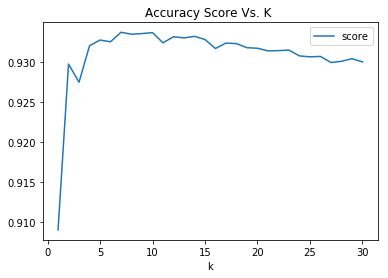

In [201]:
# plot to find best k
model_data = pd.DataFrame(scores, columns=['k','score'])
model_data.plot.line(x ='k',y ='score')
plt.title('Accuracy Score Vs. K ')
plt.savefig('knn_accuracy.png')

In [202]:
#fit model with best k
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

In [203]:
#find accuracy score and testing error
y_pred = knn.predict(X_test)
testing_accuracy = metrics.accuracy_score(y_test,y_pred)
testing_error = 1 - testing_accuracy

testing_accuracy

0.9334421203580082

In [197]:
# baseline
y_train.value_counts()/len(y_train)

1    0.894339
2    0.081429
3    0.024231
Name: grade_num, dtype: float64

#### Conclusion: 

Testing accuracy score is slightly better than the baseline, signaling a fairly accurate model. 

### LogReg Attempt

In [190]:
logreg = LogisticRegression(C=1e9, solver='lbfgs', multi_class='auto') 

print(np.mean(cross_val_score(logreg, X_train, y_train, cv=kf))) 

0.9328289375470437


In [191]:
#fit the data
logreg.fit(X_train,y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='auto', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [192]:
#train data accuracy score
logreg.score(X_train,y_train)

0.9328454158836911

In [193]:
#test data accuracy score
logreg.score(X_test,y_test)

0.9338377095386441

In [194]:
# compare with baseline
y_train.value_counts() / len(y_train)

1    0.894339
2    0.081429
3    0.024231
Name: grade_num, dtype: float64

#### Conclusion
Model seems pretty good because the two accuracy scores are very comparable. The test data accuracy score is a little higher. In addition, they are both better than the baseline, signifying a relatively good model. 

In [208]:
metrics.confusion_matrix(y_test,logreg.predict(X_test)) 

array([[17985,    61,     8],
       [  785,   889,     8],
       [  207,   269,    11]], dtype=int64)

In [209]:
y_test.shape

(20223,)

In [211]:
X_test.shape

(20223, 17)

In [ ]:
logreg.predict_proba(X)[0:10]

In [ ]:
eat['grade_pred_prob'] = logreg.predict_proba(X)[:, 1]

In [ ]:
plt.scatter(eat.al, eat.grade)
plt.plot(eat.sort_values('al').al, eat.sort_values('al').grade_pred_prob, color='red')
plt.xlabel('al')
plt.ylabel('grade')